1. IMPORTING LIBRARIES

In [1]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2. LOADING THE DATA

In [2]:
# Training Directory
training_dir = 'Training/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    for file in os.listdir(training_dir+label):
        training_paths.append(training_dir+label+'/'+file)
        train_labels.append(label)
random.shuffle(training_paths)
random.shuffle(train_labels)


# show an example of the list
training_paths[0]

'Training/glioma/Tr-gl_0774.jpg'

In [3]:
len(training_paths)

5712

In [4]:
# Testing Directory
test_dir = 'Testing/'
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
        test_labels.append(label)
random.shuffle(test_paths)
random.shuffle(test_labels)

# test_paths, test_labels = shuffle(test_paths, test_labels)

# show an example of the list
print(test_paths[0])

Testing/pituitary/Te-pi_0248.jpg


In [5]:
len(test_paths)

1311

In [6]:
labels = os.listdir(training_dir)
labels

['glioma', 'meningioma', 'notumor', 'pituitary']

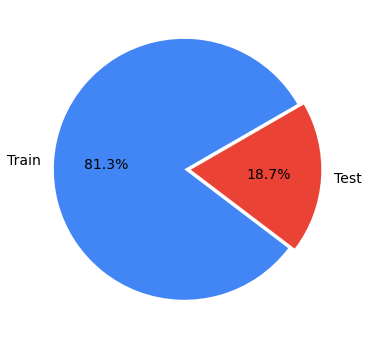

In [7]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

3. DATA AUGMENTATION

In [8]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

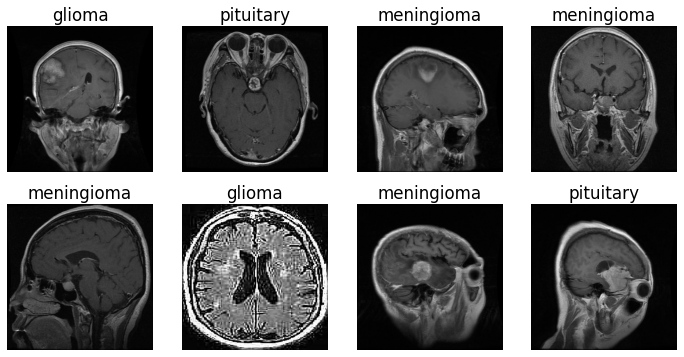

In [9]:
# i = random.randint(0,len(training_paths))
images = open_images(training_paths[50:59])
xlabels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

4. DATA GENERATOR

In [10]:
# Expand the size of a training set by creating modified data from existing one
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

5. BUILDING THE Xception MODEL

In [11]:
# Loading the Pre-Trained Model (Xception)

base_model = Xception(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [12]:
len (base_model.layers)

132

In [13]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last InceptionV3 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [14]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 37,639,340
Trainable params: 19,941,508
No

In [15]:
len (model.layers)

6

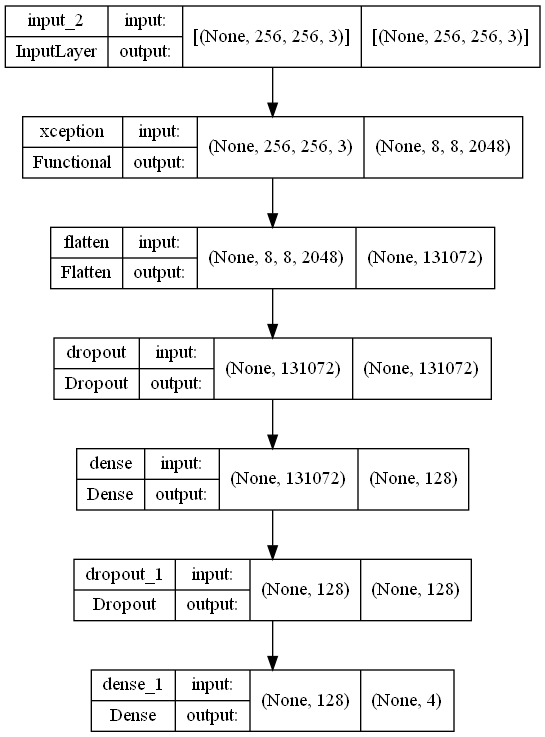

In [16]:
plot_model(model, show_shapes=True, to_file="Model Layers/xception.png")

6. TRAINING THE MODEL

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [18]:
# Training the Model

batch_size=256

history = model.fit(data_gen(training_paths), 
epochs=20,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/20
22/22 [==============================] - 45s 2s/step - loss: 1.3088 - sparse_categorical_accuracy: 0.6318 - val_loss: 0.7091 - val_sparse_categorical_accuracy: 0.7200
Epoch 2/20
22/22 [==============================] - 41s 2s/step - loss: 0.6831 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.5348 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/20
22/22 [==============================] - 41s 2s/step - loss: 0.5953 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.5000 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/20
22/22 [==============================] - 44s 2s/step - loss: 0.4403 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.4345 - val_sparse_categorical_accuracy: 0.8600
Epoch 5/20
22/22 [==============================] - 47s 2s/step - loss: 0.4746 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.6194 - val_sparse_categorical_accuracy: 0.7800
Epoch 6/20
22/22 [==============================] - 47s 2s/step - loss: 0.4769 - sparse_categorical_accuracy: 

In [19]:
model.save('mobilenet.h5')

7. EVALUATING THE MODEL

In [20]:
model = load_model ('mobilenet.h5')

In [21]:
evaluation = model.evaluate(data_gen(test_paths))

print('Test Loss:', evaluation[0])
print ('Test Accuracy:', evaluation[1])

132/132 [==============================] - 177s 1s/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9024
Test Loss: 0.2580086588859558
Test Accuracy: 0.9023646116256714


Predicted: notumor
Actual: notumor


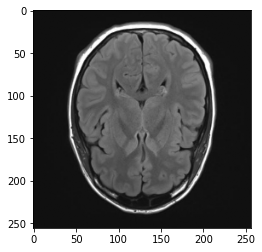

In [22]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

In [23]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


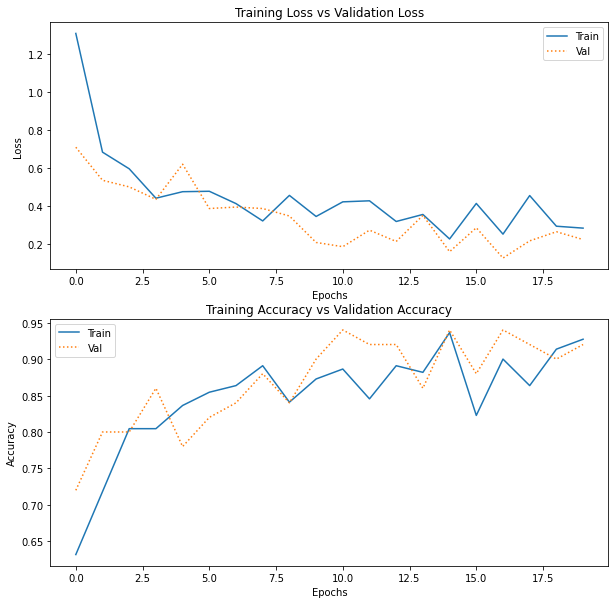

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

8. CLASSIFICATION REPORT AND CONFUSION MATRIX

In [25]:
# For Confusion Matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(test_dir, target_size=(256,256), shuffle=False, seed=21,
                                                     class_mode='sparse', batch_size=16)

Found 1311 images belonging to 4 classes.


In [26]:
classes = labels
#On test dataset
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

82/82 [==============================] - 169s 2s/step


In [27]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.96      0.79      0.86       300
  meningioma       0.80      0.83      0.82       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.86      0.99      0.92       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



In [29]:
# For Confusion Matrix
target_labels = ["glioma", "meningioma", "notumor", "pituitary"]

Generator = ImageDataGenerator(rescale=1./255)
test_gen = Generator.flow_from_directory(test_dir,
                                        # resizing testing images to (min(heights), min(widths)) in both trainining and testing sets
                                          target_size = (256,256),
                                          color_mode = 'rgb',
                                          classes = target_labels,
                                          class_mode = 'sparse',
                                          batch_size = 16,
                                          shuffle = False,
                                         )

Found 1311 images belonging to 4 classes.


In [30]:
def test_model(model, test_generator):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    print(y_pred[:10])
    return y_pred

In [31]:
y_pred = test_model(model, test_gen)
print(y_pred[:10])

82/82 [==============================] - 170s 2s/step
(1311, 4)
[[9.9960977e-01 2.4896485e-04 1.2650079e-04 1.4694214e-05]
 [9.7912300e-01 1.6753847e-02 1.3455586e-04 3.9885361e-03]
 [9.9936658e-01 3.4841688e-04 2.5076148e-04 3.4248940e-05]
 [1.2208800e-01 8.4102106e-01 2.6865217e-03 3.4204435e-02]
 [3.5404864e-01 2.4849144e-01 9.7928680e-03 3.8766706e-01]
 [8.6343396e-01 1.3326940e-01 3.1296415e-03 1.6700075e-04]
 [9.9962401e-01 2.5832999e-04 2.3103577e-05 9.4542447e-05]
 [9.9997818e-01 7.4964669e-06 1.3624268e-05 7.7846801e-07]
 [9.9029362e-01 2.3761163e-03 5.3670997e-04 6.7935945e-03]
 [9.9988747e-01 8.4156411e-05 1.2342529e-05 1.5942866e-05]]
[[9.9960977e-01 2.4896485e-04 1.2650079e-04 1.4694214e-05]
 [9.7912300e-01 1.6753847e-02 1.3455586e-04 3.9885361e-03]
 [9.9936658e-01 3.4841688e-04 2.5076148e-04 3.4248940e-05]
 [1.2208800e-01 8.4102106e-01 2.6865217e-03 3.4204435e-02]
 [3.5404864e-01 2.4849144e-01 9.7928680e-03 3.8766706e-01]
 [8.6343396e-01 1.3326940e-01 3.1296415e-03 1.6700

In [32]:
Y_pred = (y_pred > 0.5).astype(int)
print(Y_pred[:10])

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [33]:
print(test_gen.labels[:10])

[0 0 0 0 0 0 0 0 0 0]


In [34]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_gen.labels)
print(test_labels[:10])

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [35]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 10):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [36]:
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (15, 5))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["POSITIVE", "NEGATIVE" ])

    fig.tight_layout()
    plt.show()

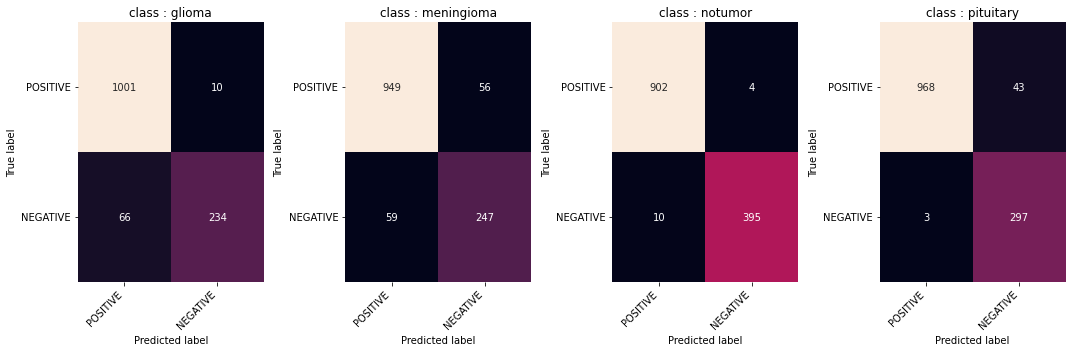

In [37]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])
plot_confusion_matrices(conf_matrices, target_labels)

9. TEST WITH EXTERNAL DATASET

In [38]:
# Testing Directory
test2_dir = 'Testing_/'
test2_paths = []
test2_labels = []
for label in os.listdir(test2_dir):
    for file in os.listdir(test2_dir+label):
        test2_paths.append(test2_dir+label+'/'+file)
        test2_labels.append(label)
random.shuffle(test2_paths)
random.shuffle(test2_labels)

# test_paths, test_labels = shuffle(test_paths, test_labels)

# show an example of the list
print(test2_paths[0])

Testing_/notumor/image(24).jpg


In [39]:
len(test2_paths)

394

In [40]:
evaluation = model.evaluate(data_gen(test2_paths))

print('Test Loss:', evaluation[0])
print ('Test Accuracy:', evaluation[1])

40/40 [==============================] - 52s 1s/step - loss: 1.5336 - sparse_categorical_accuracy: 0.6904
Test Loss: 1.5335743427276611
Test Accuracy: 0.6903553009033203


In [41]:

test_generator2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_generator2.flow_from_directory(test2_dir, target_size=(256,256), shuffle=False, seed=21,
                                                     class_mode='sparse', batch_size=16)

Found 394 images belonging to 4 classes.


In [42]:
labels2 = os.listdir(test2_dir) 
labels2

['glioma', 'meningioma', 'notumor', 'pituitary']

In [43]:
classes = labels2
#On test2 dataset
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

In [44]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator2.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.86      0.12      0.21       100
  meningioma       0.66      0.86      0.75       115
     notumor       0.78      0.90      0.84       105
   pituitary       0.61      0.89      0.73        74

    accuracy                           0.69       394
   macro avg       0.73      0.69      0.63       394
weighted avg       0.73      0.69      0.63       394

